In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
images = []
y_train = []
for dicname in sorted(os.listdir("./train/")):           #filedir = "dicname"
    
    train_folder_path = os.path.join(os.getcwd(), "train", dicname)
    for filename in sorted(os.listdir(train_folder_path)):
        
        img = cv2.imread(os.path.join(train_folder_path, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (336,336))
            images.append(img)
            
            if dicname == "daisy":
                y_train.append(0)
            elif dicname == "dandelion":
                y_train.append(1)
            elif dicname == "rose":
                y_train.append(2)
            elif dicname == "sunflower":
                y_train.append(3)
            elif dicname == "tulip":
                y_train.append(4)
                
x_train = np.array(images)
#y_train = np.array(y_train)
#y_trian =  pd.get_dummies(y_train)
#y_train = np.array(y_train)

In [3]:
y_train= pd.get_dummies(y_train)
y_train = np.array(y_train)
print(y_train.shape)
print(x_train.shape)

(3823, 5)
(3823, 336, 336, 3)


[1 0 0 0 0]


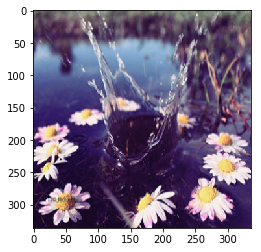

In [4]:
print(y_train[2])
plt.imshow(x_train[1])

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state= 20, shuffle=True)
print("x_train shape:", x_train.shape)
print("numbers of training sample:", x_train.shape[0])
print("numbers of testing sample:", y_train.shape)

x_train shape: (3058, 336, 336, 3)
numbers of training sample: 3058
numbers of testing sample: (3058, 5)


In [7]:
import keras
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.applications import vgg16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras import backend as K
from keras.layers.normalization import BatchNormalization

#base_model = vgg16.VGG16(weights='imagenet', include_top=False,input_shape = (300,300,3)) 
#base_model = DenseNet121(weights='imagenet', include_top=False,input_shape = (350,350,3)) 
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape = (336,336,3))

for layer in base_model.layers:
    layer.trainable = True
# 添加全局平均池化层

x = base_model.output
#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# 添加一个全连接层

x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# 添加一个分类器，假设我们有200个类

predictions = Dense(5, activation='softmax')(x)
# 构建我们需要训练的完整模型

model = Model(inputs=base_model.input, outputs=predictions)

# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 InceptionV3 的卷积层


# 编译模型（一定要在锁层以后操作）
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



In [8]:
from keras.optimizers import SGD, Adam, Adagrad

#model = VGG_16()
optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0001, nesterov=False)
#optimizer = Adam(lr=0.001)
#optimizer = Adagrad(lr=0.001, epsilon=None, decay=0.0)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_train /= 255.
x_valid /= 255.

In [9]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=0,  # randomly rotate images in the range -30~30
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

Using real-time data augmentation.


In [10]:
#os.chdir('///home/jovyan/program/DL/11_1下tensorflow_simpson')
save_dir = os.path.join(os.getcwd(),'saved_model')
print(os.getcwd())
model_name = "classification_cnndensenet_model1"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose =1)

/home/jovyan/Kaggle_test/midtern_image


In [11]:
#model.summary()

In [12]:
y_train

array([[0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [13]:
batch_size = 20
epochs = 100
#workers = 用4個GPU
#verbose是否再進度調顯示
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                batch_size = batch_size),
                         epochs = epochs,
                         workers = 4,
                         validation_data = (x_valid, y_valid),
                         callbacks = [checkpoint, earlystop])
#model_history = model.fit(x_train, y_train,validation_data=(x_valid, y_valid), epochs=20, batch_size=20);                                   
print("Loading trained model")
model = load_model(model_path)

Epoch 1/100
153/153 [==============================] - 67s 438ms/step - loss: 0.6977 - acc: 0.7554 - val_loss: 0.3997 - val_acc: 0.8758

Epoch 00001: val_loss improved from inf to 0.39967, saving model to /home/jovyan/Kaggle_test/midtern_image/saved_model/classification_cnndensenet_model1
Epoch 2/100
153/153 [==============================] - 48s 311ms/step - loss: 0.3085 - acc: 0.8970 - val_loss: 0.4310 - val_acc: 0.8510

Epoch 00002: val_loss did not improve from 0.39967
Epoch 3/100
153/153 [==============================] - 48s 313ms/step - loss: 0.1913 - acc: 0.9356 - val_loss: 0.2952 - val_acc: 0.9150

Epoch 00003: val_loss improved from 0.39967 to 0.29524, saving model to /home/jovyan/Kaggle_test/midtern_image/saved_model/classification_cnndensenet_model1
Epoch 4/100
153/153 [==============================] - 48s 311ms/step - loss: 0.1448 - acc: 0.9532 - val_loss: 0.2876 - val_acc: 0.9111

Epoch 00004: val_loss improved from 0.29524 to 0.28762, saving model to /home/jovyan/Kaggle

In [14]:
#print(pd.DataFrame(model.predict(x_valid)))

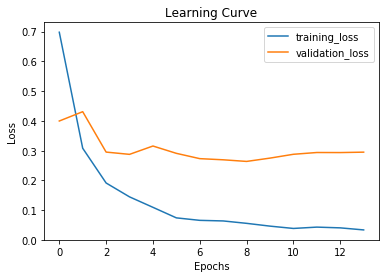

In [15]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

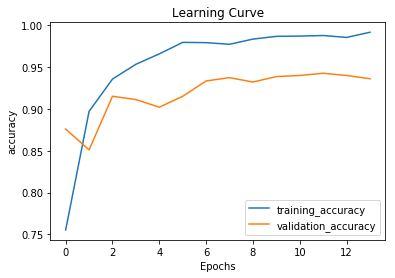

In [16]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [17]:
scores = model.evaluate(x_valid, y_valid, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

765/765 [==============================] - 5s 7ms/step
Test loss: 0.26389267555638857
Test accuracy: 0.9320261430896185


In [18]:
example = pd.read_csv("submission.csv")

In [19]:
import os
test_set = []

'''
for filename in sorted(os.listdir("./testset/")):
    img = cv2.imread(os.path.join("./testset/",filename))
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224,224))
        test_set.append(img)
'''
for filename in example.iloc[:,0].values:
    filename = filename+".jpg"
    img = cv2.imread(os.path.join("./test/",filename,))
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (336,336))
        test_set.append(img)
        
test_set = np.array(test_set)
test_set = test_set.astype('float32')
test_set /= 255

In [20]:
#print(model.predict(test_set))
#result = np.argmax(test_pred, axis =1)
#result = np.argmax(model.predict(test_set), axis =1)
#result

In [21]:
test_set.shape

(500, 336, 336, 3)

In [22]:
id_test=[]
for filename in example.iloc[:,0].values:
    #filename = filename.rstrip(".jpg")
    id_test.append(filename)

In [23]:
id_test = np.array(id_test)

In [24]:
test_pred =model.predict(test_set)
result = np.argmax(test_pred, axis =1)
output = list(zip(id_test, result))
df = pd.DataFrame(data = output, columns=['id','class'])
df.to_csv('result_densenet.csv', index =False, header = True)

In [25]:
#example.iloc[:,0].values

In [26]:
output

[('100080576_f52e8ee070_n', 0),
 ('1008566138_6927679c8a', 3),
 ('100930342_92e8746431_n', 4),
 ('1022552002_2b93faf9e7_n', 3),
 ('1022552036_67d33d5bd8_n', 3),
 ('102501987_3cdb8e5394_n', 2),
 ('102841525_bd6628ae3c', 0),
 ('1031799732_e7f4008c03', 0),
 ('1043442695_4556c4c13d_n', 3),
 ('1044296388_912143e1d4', 3),
 ('10443973_aeb97513fc_m', 1),
 ('105806915_a9c13e2106_n', 0),
 ('1064662314_c5a7891b9f_m', 3),
 ('10683189_bd6e371b97', 1),
 ('1074999133_1e4a1e042e', 1),
 ('107592979_aaa9cdfe78_m', 3),
 ('107693873_86021ac4ea_n', 4),
 ('10791227_7168491604', 4),
 ('1080179756_5f05350a59', 1),
 ('10919961_0af657c4e8', 1),
 ('110147301_ad921e2828', 2),
 ('110472418_87b6a3aa98_m', 2),
 ('112334842_3ecf7585dd', 4),
 ('112428665_d8f3632f36_n', 4),
 ('112428919_f0c5ad7d9d_n', 4),
 ('112650879_82adc2cc04_n', 4),
 ('112651128_7b5d39a346_m', 4),
 ('112951022_4892b1348b_n', 4),
 ('112951086_150a59d499_n', 4),
 ('113291410_1bdc718ed8_n', 4),
 ('113902743_8f537f769b_n', 4),
 ('113960470_38fab8f2fb_m